In [1]:
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface

regex_m = RegexModel()
dataloader = AnnotationDataLoader()


In [2]:
## Evalute model
regex_m_wrapper = ModelEvalWrapper(regex_m, "regex")
m = ModelEvaluator(regex_m_wrapper, dataloader.get_train())

c_report = m.generate_report()
# c_report.show_report()


'iVBORw0KGgoAAAANSUhEUgAABg4AAAVNCAYAAAAsCbD3AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzdd3gUVd/G8TuFkARCCCT03ps06SBNiggiAoKAIlWx4KOCFQR8eAUUuyJYqCIIKEU6IkWQ3nvvECABQihJIMm8f/AwMrubZHezSSjfz3Xl0nMyp2yYzEzOb845XoZhGAIAAAAAAAAAAJDkndEdAAAAAAAAAAAAdw8CBwAAAAAAAAAAwETgAAAAAAAAAAAAmAgcAAAAAAAAAAAAE4EDAAAAAAAAAABgInAAAAAAAAAAAABMBA4AAAAAAAAAAICJwAEAAAAAAAAAADAROAAAAAAAAAAAACYCBwAAAAAAAAAAwETgAAAAAAAAAAAAmAgcAAAAAAAAAAAAE4EDAAAAAAAAAABgInAAAAAAAAAAAABMBA4AAAAAAAAAAICJwAEAAAAAAAAAADAROAAAAAAAAAAAACYCBwAAAAAAAAAAwETgAAAAAAAAAAAAmAgcAAAAAAAAAAAAE4EDAAAAAAAAAABgInAAAAAAAAAAAABMBA4AAAAAAAAAAICJwAEAAAAAAAAAADAROAAAAAAAAAAAACYCBwAAAAAAAAAAwETgAAAAAAAAAAAAmAgcAAAAAAAAAAAAE4EDAAAAAAAAAABgInAAAABwnzp37pw++eQTtW7dWkWLFlVwcLC8vb3l5eVlfrVp0yaju5khGjZsaPk5NGzYMKO7BNz1hgwZYvm98fLyyuguZYgBAwZYfgajR4/O6C45rVu3bpa+FylSJKO7dN8pUqSI5WfcrVu3jO4SkCSuCXent956y/LvMnbs2IzuEh5QvhndAQAA8GAxDEMHDhzQoUOHdPLkSV25ckVxcXEKCgpSSEiIcuT

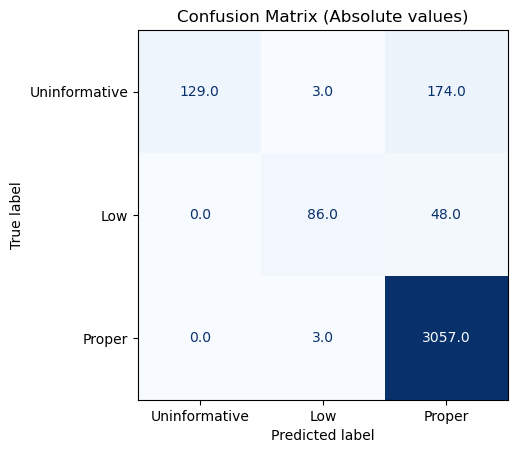

In [3]:

c_report._display_cm_abs_plot()

,precision,recall,f1-score,support
Uninformative,1.00000,0.42157,0.59310,306
Low,0.93478,0.64179,0.76106,134
Proper,0.93230,0.99902,0.96451,"3,060"


Accuracy,0.934857


,precision,recall,f1-score,support
Weighted Average,0.93831,0.93486,0.92425,"3,500"
Macro Average,0.95569,0.68746,0.77289,"3,500"


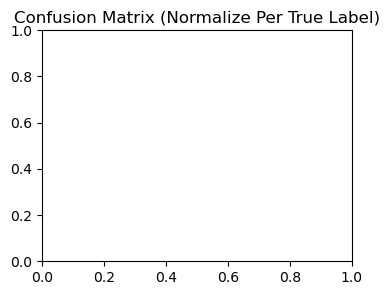

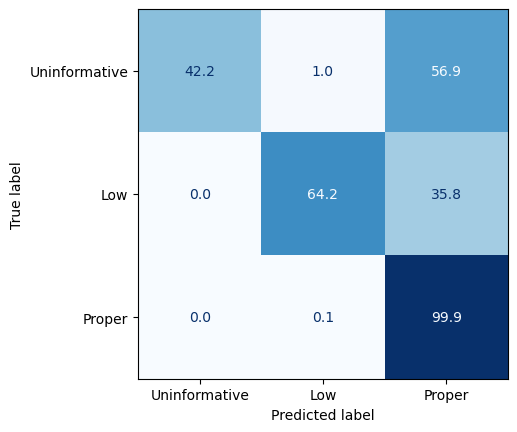

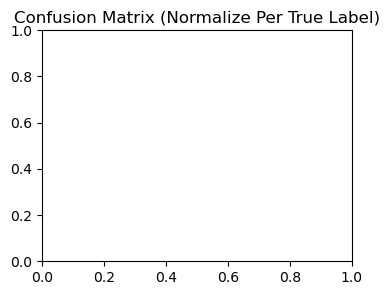

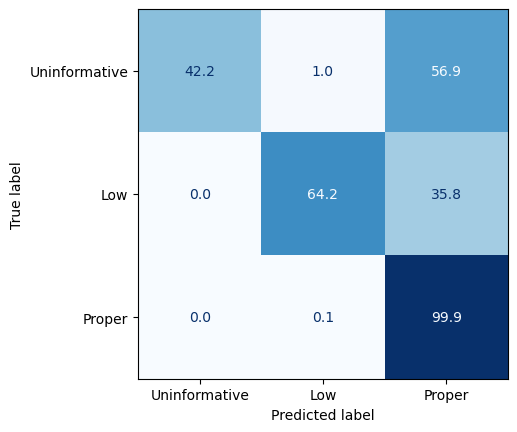

In [3]:
self = c_report
# # the axis the plot will use
# cm_plot_abs = fig.add_subplot(gs[0, 0]) # row 0, col 0
# cm_plot_norm = fig.add_subplot(gs[0, 1])
# mem_plot = fig.add_subplot(gs[1, :])
# cpu_plot = fig.add_subplot(gs[2, :])


# # abs values
# cm_plot_abs.set_title("Confusion Matrix (Absolute values)")
# cm_disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, 
#                                     display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
#                                     )

# cm_disp.plot(ax=cm_plot_abs, cmap="Blues", values_format=".1f", colorbar=False)


# # relative per label
# cm_plot_norm.set_title("Confusion Matrix (Normalize Per True Label)")

# normalize_per_label = self.cm.astype(float) / self.cm.sum(axis=1, keepdims=True) * 100 

# cm_disp = ConfusionMatrixDisplay(confusion_matrix=normalize_per_label, 
#                                     display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
#                                     )

# cm_disp.plot(ax=cm_plot_norm, cmap="Blues", values_format=".1f", colorbar=False)

# plt.tight_layout()


import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import numpy as np

self._display_titles()


self._display_metrics()

# --- Create output widgets ---
cell_00 = widgets.Output(layout=widgets.Layout(width='300px', height='300px'))
cell_01 = widgets.Output(layout=widgets.Layout(width='300px', height='300px'))
# cell_10 = widgets.Output(layout=widgets.Layout(width='300px', height='300px'))
# cell_11 = widgets.Output(layout=widgets.Layout(width='300px', height='300px'))

x = np.linspace(0,10,100)

with cell_00:
    self._display_cm_rel_plot()

with cell_01:
    self._display_cm_rel_plot()

# with cell_10:
#     self._display_cm_abs_plot()

# with cell_11:
#     pass
#     self._display_cm_abs_plot()

    # self._display_cpu_usage_plot()

    
# # --- Arrange in a 2x2 grid ---
# grid = widgets.GridBox(
#     children=[cell_00, cell_01, cell_10, cell_11],
#     layout=widgets.Layout(
#         grid_template_columns="400px 400px",
#         grid_template_rows="300px 300px",
#         grid_gap="10px"
#     )
# )
display(widgets.HBox([cell_00, cell_01]))

# display(grid)



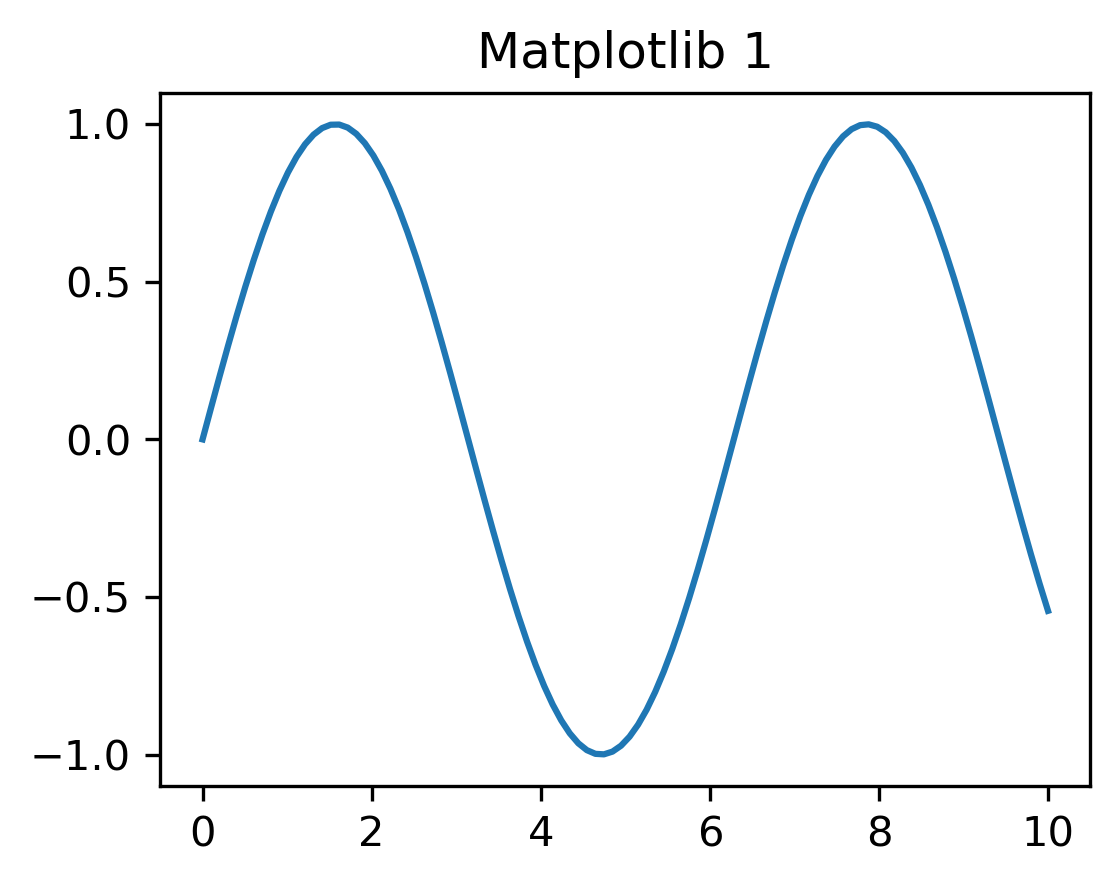
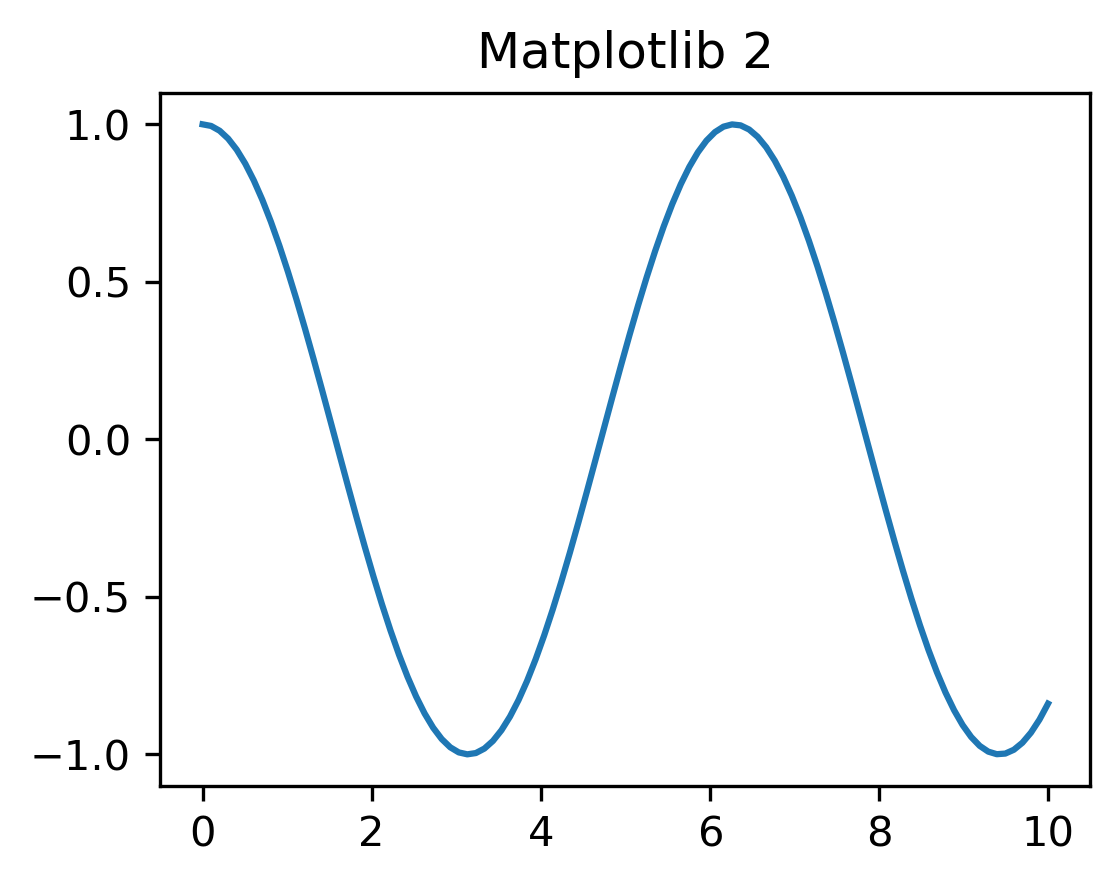

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import numpy as np
import io, base64

x = np.linspace(0, 10, 100)

# --- Matplotlib figure 1 ---
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x, np.sin(x))
ax.set_title("Matplotlib 1")
plt.close(fig)
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight',dpi=300)
buf.seek(0)
img1 = base64.b64encode(buf.read()).decode('utf-8')

# --- Matplotlib figure 2 ---
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x, np.cos(x))
ax.set_title("Matplotlib 2")
plt.close(fig)
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', dpi=300)
buf.seek(0)
img2 = base64.b64encode(buf.read()).decode('utf-8')



# --- Plotly figure 1 ---
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=x, y=np.sin(x)*0.5, mode='lines'))
fig3.update_layout(width=400, height=300, title="Plotly 1")
plotly_html1 = fig3.to_html(include_plotlyjs='cdn', full_html=False)

# --- Plotly figure 2 ---
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=x, y=np.cos(x)*0.5, mode='lines'))
fig4.update_layout(width=400, height=300, title="Plotly 2")
plotly_html2 = fig4.to_html(include_plotlyjs='cdn', full_html=False)

# --- Combine in HTML grid ---
html = f"""
<div style="display: grid; grid-template-columns: 50% 50%; grid-gap: 10px;">
    <div style="border:1px solid gray; padding:5px;"><img src="data:image/png;base64,{img1}" style="width:100%"></div>
    <div style="border:1px solid gray; padding:5px;"><img src="data:image/png;base64,{img2}" style="width:100%"></div>
    <div style="border:1px solid gray; padding:5px;">{plotly_html1}</div>
    <div style="border:1px solid gray; padding:5px;">{plotly_html2}</div>
</div>
"""

display(HTML(html))


In [11]:
import pandas as pd
self = c_report

print("Metrics per label\n")
print(pd.DataFrame(self.metric_per_label))

print(f"\nAccuracy: {self.accuracy}\n")

print("\nMacro Average\n")
print(pd.DataFrame([self.macro_avg]).to_string(index=False))


print("\nWeighted Average\n")
print(pd.DataFrame([self.weighted_avg]).to_string(index=False))



Metrics per label

           Uninformative         Low       Proper
precision       1.000000    0.934783     0.932296
recall          0.421569    0.641791     0.999020
f1-score        0.593103    0.761062     0.964505
support       306.000000  134.000000  3060.000000

Accuracy: 0.9348571428571428


Macro Average

 precision  recall  f1-score  support
  0.955693 0.68746   0.77289   3500.0

Weighted Average

 precision   recall  f1-score  support
  0.938311 0.934857  0.924245   3500.0


,precision,recall,f1-score,support
Uninformative,1.00000,0.42157,0.59310,306
Low,0.93478,0.64179,0.76106,134
Proper,0.93230,0.99902,0.96451,"3,060"


Accuracy,0.934857


,precision,recall,f1-score,support
Weighted Average,0.93831,0.93486,0.92425,"3,500"
Macro Average,0.95569,0.68746,0.77289,"3,500"


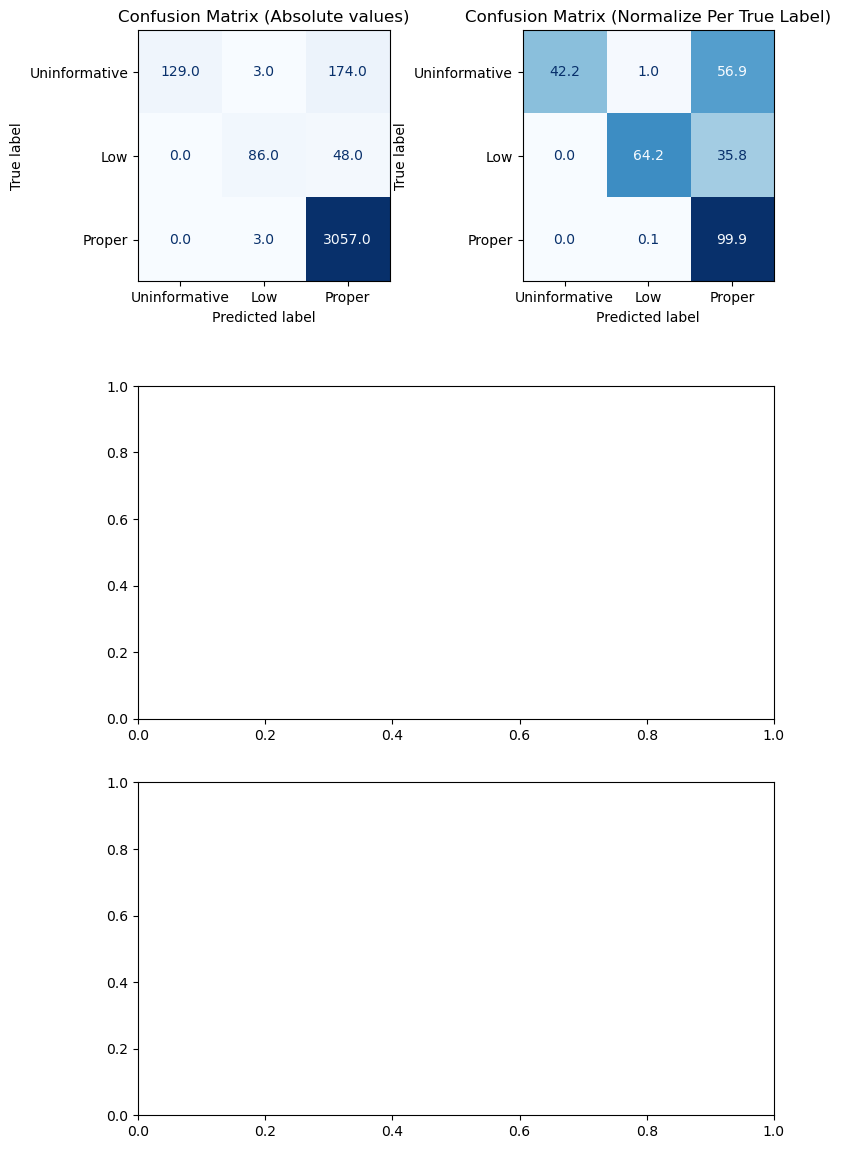

In [ ]:
from IPython.display import display, HTML

import pandas as pd
import time
import psutil
import os
import tracemalloc, time
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from typing import Protocol, runtime_checkable
from models.config import AnnotationLabels
import threading
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# table_style = [
#         {'selector': 'caption',
#          'props': [('caption-side', 'top'),
#                    ('font-size', '18px'),
#                    ('font-weight', 'bold'),
#                    ('padding', '10px 0')]},       # Header cells
#         {'selector': 'th',
#          'props': [('background-color', '#2c3e50'),
#                    ('color', 'white'),
#                    ('font-size', '14px'),
#                    ('text-align', 'center'),
#                    ('padding', '8px 16px')]},  # ← padding here

#         # Data cells
#         {'selector': 'td',
#          'props': [('font-size', '13px'),
#                    ('text-align', 'center'),
#                    ('padding', '12px 18px')]},  # ← padding here

#         # Table borders and spacing
#         {'selector': 'table',
#          'props': [('border-collapse', 'separate'),
#                    ('border-spacing', '0 6px')]},  # spacing between rows
#         {'selector': 'table',
#             'props': [('margin-left', 'auto'),
#                     ('margin-right', 'auto'),
#                     ('text-align', 'center')]}
#         ]



# ####### Title
# model_title = "Model 1"

# HTML_title = f"""<div style="font-size:20px; line-height:1; margin-bottom:1px;">
#                  <h2 style='margin-bottom:-10px;'>Performance Report: {model_title}</h2>
#                  </div>"""

# display(HTML(HTML_title))

# ###### Subtitle
# model_info = "BERT with 10 epochs of traning, default train params"
# HTML_subtitle = f"""<div style=" line-height:1; margin-bottom:1px;">
#                  <h3 style='margin-bottom:1px;'>{model_info}</h2>
#                  </div>"""

# display(HTML(HTML_subtitle))


# ###### Metric per label
# metric_per_label_df = pd.DataFrame(self.metric_per_label).T

# metric_per_label_df_styled = metric_per_label_df.style.set_caption("Metrics per Label") \
#     .set_table_styles(table_style).format({
#         "precision": "{:,.5f}",
#         "recall": "{:,.5f}",    
#         "f1-score": "{:,.5f}",       
#         "support": "{:,.0f}"        
#     })


# display(metric_per_label_df_styled)

# ###### Accuracy
# pd.DataFrame([{"Accuracy": self.accuracy}]).T

# accuracy_df = pd.DataFrame([{"Accuracy": self.accuracy}]).T
# accuracy_df_styled = accuracy_df.style.hide(axis=1).set_caption("Accuracy") \
#     .set_table_styles(table_style).format({
#         "precision": "{:,.5f}",
#         "recall": "{:,.5f}",    
#         "f1-score": "{:,.5f}",       
#         "support": "{:,.0f}"        
#     })

# display(accuracy_df_styled)

# ###### weighted and macro average
# weighted_and_macro_avg_df = pd.DataFrame({"Weighted Average": self.weighted_avg, "Macro Average": self.macro_avg}).T
# weighted_and_macro_avg_df_styled = weighted_and_macro_avg_df.style.set_caption("Weighted and Macro Avg") \
#     .set_table_styles(table_style).format({
#         "precision": "{:,.5f}",
#         "recall": "{:,.5f}",    
#         "f1-score": "{:,.5f}",       
#         "support": "{:,.0f}"        
#     })

# display(weighted_and_macro_avg_df_styled)



#############
# create the subplot layout
fig = plt.figure(figsize=(8, 12))  # figsize optional

gs = GridSpec(3, 2, figure=fig)  # 3 rows × 2 columns


# the axis the plot will use
cm_plot_abs = fig.add_subplot(gs[0, 0]) # row 0, col 0
cm_plot_norm = fig.add_subplot(gs[0, 1])
mem_plot = fig.add_subplot(gs[1, :])
cpu_plot = fig.add_subplot(gs[2, :])


# # abs values
# cm_plot_abs.set_title("Confusion Matrix (Absolute values)")
# cm_disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, 
#                                     display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
#                                     )

# cm_disp.plot(ax=cm_plot_abs, cmap="Blues", values_format=".1f", colorbar=False)


# # relative per label
# cm_plot_norm.set_title("Confusion Matrix (Normalize Per True Label)")

# normalize_per_label = self.cm.astype(float) / self.cm.sum(axis=1, keepdims=True) * 100 

# cm_disp = ConfusionMatrixDisplay(confusion_matrix=normalize_per_label, 
#                                     display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
#                                     )

# cm_disp.plot(ax=cm_plot_norm, cmap="Blues", values_format=".1f", colorbar=False)

# plt.tight_layout()






In [ ]:


### the mem usage plot
mem_records_df = pd.DataFrame(list(self.memory_records.items()), columns=["TimeDelta", "MemUsage"])
# only ge mem usage delta
mem_usage_t0 = mem_records_df[mem_records_df["TimeDelta"] == 0]["MemUsage"][0]
mem_records_df["MemUsageDelta"] = mem_records_df["MemUsage"] - mem_usage_t0
# convert mem usage to MB
mem_records_df["MemUsageDeltaMB"] = mem_records_df["MemUsageDelta"] / (1024 * 1024)

mem_plot.plot(mem_records_df["TimeDelta"], mem_records_df["MemUsageDeltaMB"])
mem_plot.set_title("Memory Usage")
mem_plot.set_xlabel("Time (seconds)")
mem_plot.set_ylabel("Delta memory usage(MB)")



# ### Cpu plot        
# cpu_records_df = pd.DataFrame(list(self.cpu_usage_records.items()), columns=["TimeDelta", "CPUUsage"])

# cpu_plot.plot(cpu_records_df["TimeDelta"], cpu_records_df["CPUUsage"])
# cpu_plot.set_title("CPU Usage across all cores")
# cpu_plot.set_xlabel("Time (seconds)")
# cpu_plot.set_ylabel("CPU Usage (%) of cores (100% = 1 core)")




Text(100.75000000000001, 0.5, 'CPU Usage (%) of cores (100% = 1 core)')

In [ ]:
# create the subplot layout
fig = plt.figure(figsize=(8, 12))  # figsize optional

gs = GridSpec(3, 2, figure=fig)  # 3 rows × 2 columns


# the axis the plot will use
cm_plot_abs = fig.add_subplot(gs[0, 0]) # row 0, col 0
cm_plot_norm = fig.add_subplot(gs[0, 1])
# mem_plot = fig.add_subplot(gs[1, :])
# cpu_plot = fig.add_subplot(gs[2, :])


# abs values
cm_plot_abs.set_title("Confusion Matrix (Absolute values)")
cm_disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, 
                                    display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
                                    )

cm_disp.plot(ax=cm_plot_abs, cmap="Blues", values_format=".1f", colorbar=False)


# relative per label
cm_plot_norm.set_title("Confusion Matrix (Normalize Per True Label)")

normalize_per_label = self.cm.astype(float) / self.cm.sum(axis=1, keepdims=True) * 100 

cm_disp = ConfusionMatrixDisplay(confusion_matrix=normalize_per_label, 
                                    display_labels=[AnnotationLabels.id2label[i] for i in self.cm_display_labels]
                                    )

cm_disp.plot(ax=cm_plot_norm, cmap="Blues", values_format=".1f", colorbar=False)

plt.tight_layout()




# import plotly.graph_objects as go


# time = cpu_records_df["TimeDelta"]
# cpu_usage = cpu_records_df["CPUUsage"]


# # Find peak CPU usage
# peak_idx = cpu_usage.idxmax()
# peak_time = time.iloc[peak_idx]
# peak_value = cpu_usage.iloc[peak_idx]

# # Create interactive plot
# fig = go.Figure()

# # CPU usage line
# fig.add_trace(go.Scatter(
#     x=time,
#     y=cpu_usage,
#     mode='lines+markers',
#     fill='tozeroy',            # adds shadow under the line
#     fillcolor='rgba(31,119,180,0.2)',  # semi-transparent fill
#     name='Delta CPU Usage (% - 100% = 1 Core)',
#     line=dict(color="#1B4EAC", width=2),
#     hovertemplate='Time: %{x}<br>CPU: %{y:.1f}%'
# ))

# # Highlight peak
# fig.add_trace(go.Scatter(
#     x=[peak_time],
#     y=[peak_value],
#     mode='markers+text',
#     name='Peak CPU',
#     marker=dict(color='red', size=12, symbol='triangle-up'),
#     text=["Peak CPU"],
#     textposition='top center',
#     hovertemplate='Peak CPU at %{x}: %{y:.1f}%'
# ))

# # Layout
# fig.update_layout(
#     title='Delta CPU Usage While Predicting',
#     xaxis_title='Time',
#     yaxis_title='Delta PU Usage (%)',
#     hovermode='x unified',
#     plot_bgcolor="rgba(31,119,180,0.1)",
#     template='plotly',  # matches VSCode dark theme
#     legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.5)')
    
# )

# fig.show()



NameError: name 'plt' is not defined

In [5]:
self = c_report

,precision,recall,f1-score,support
Uninformative,1.00000,0.42157,0.59310,306
Low,0.93478,0.64179,0.76106,134
Proper,0.93230,0.99902,0.96451,"3,060"


Accuracy,0.934857


,precision,recall,f1-score,support
Weighted Average,0.93831,0.93486,0.92425,"3,500"
Macro Average,0.95569,0.68746,0.77289,"3,500"


GridBox(children=(Output(layout=Layout(height='300px', width='300px')), Output(layout=Layout(height='300px', w…

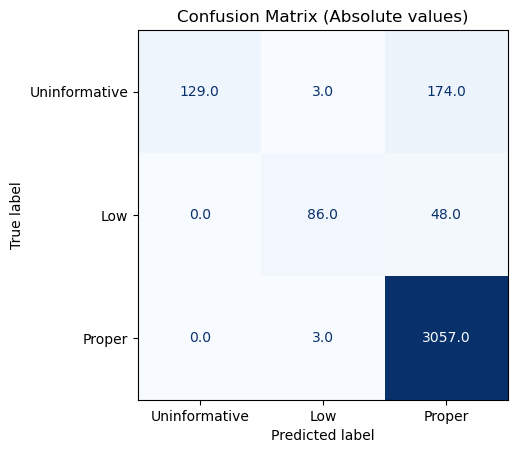

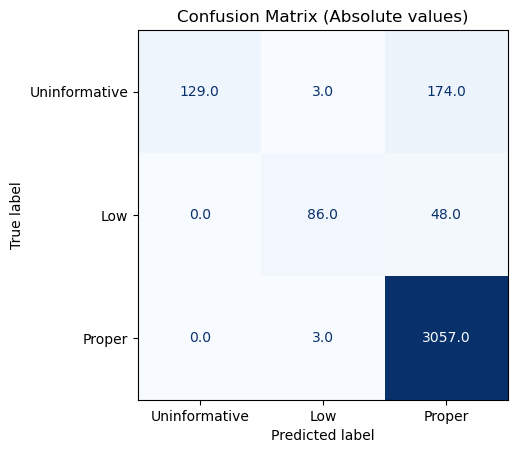

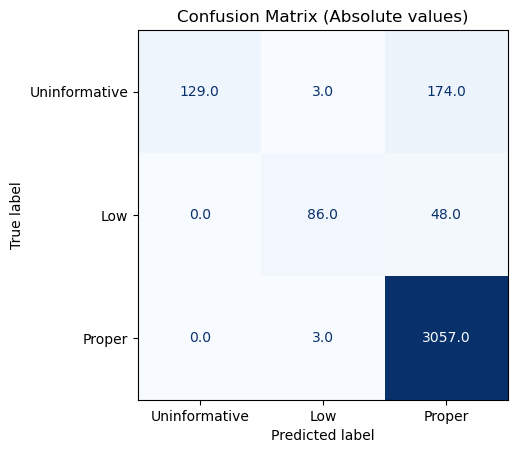

In [19]:
fig.show()

C:\Users\Elon\AppData\Local\Temp\ipykernel_10864\89474557.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [ ]:
from models.pretrained_embedder.embedder_classifier import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface


#####	 Report for Model: fembedder	

              precision    recall  f1-score   support

           0       0.89      0.75      0.81        87
           1       1.00      0.87      0.93        39
           2       0.97      0.99      0.98       874

    accuracy                           0.97      1000
   macro avg       0.95      0.87      0.91      1000
weighted avg       0.97      0.97      0.97      1000

The model took 4.83818 seconds to run

Average time per prediction 0.00484 seconds



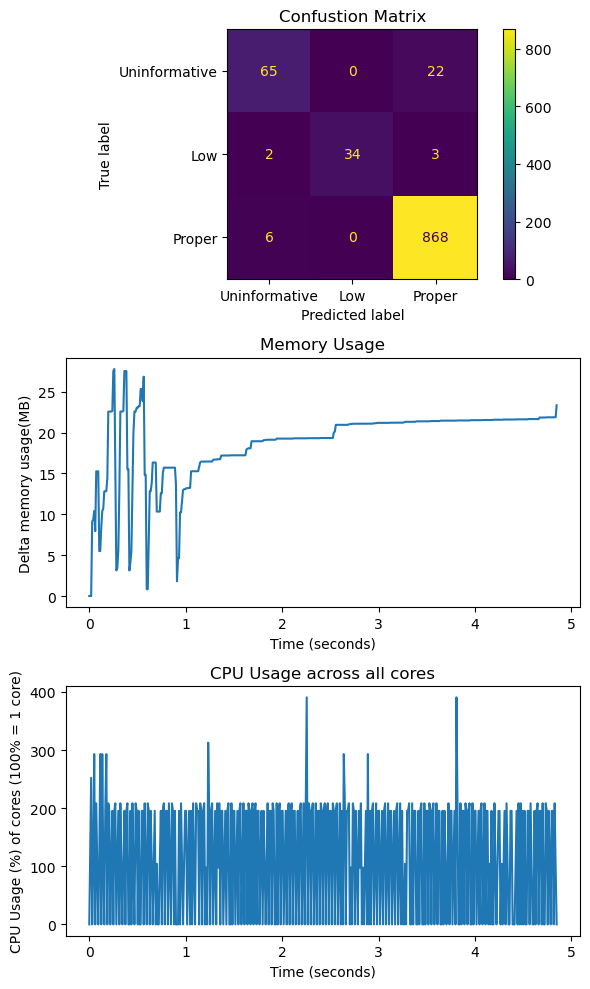

In [5]:

embedder_m = EmbedderClassifier()
dataloader = AnnotationDataLoader()

embedder_m.train(dataloader.get_train())

eval_wrapper =  ModelEvalWrapper(embedder_m, "embedder")
m = ModelEvaluator(eval_wrapper, dataloader.get_validation())
c_report = m.generate_report()
c_report.show_report()



In [19]:
### make the relative imports work in jp
##
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
##
import os
import pandas as pd
from math import isclose
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression


In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
dataloader = AnnotationDataLoader()
train_XY = dataloader.get_train()
embeddings = model.encode(train_XY["X"])
clf = LogisticRegression(max_iter=1000)
clf.fit(embeddings, train_XY["y"])


In [28]:
eval_XY = dataloader.get_validation()
embeddings = model.encode(eval_XY["X"])
preds = clf.predict(embeddings)

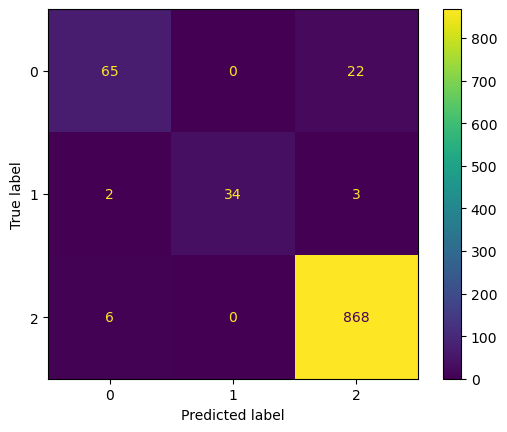

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_XY['y'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
